<a href="https://colab.research.google.com/github/alistair0111/TensorFlow-In-Practice/blob/master/Natural%20Language%20Processing%20in%20TensorFlow/NLP_Week4_Exercise_Shakespeare_Question.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [0]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
# Figure out how to import regularizers
###
import tensorflow.keras.utils as ku 
import numpy as np 

In [4]:
tokenizer = Tokenizer()
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt \
    -O /tmp/sonnets.txt
data = open('/tmp/sonnets.txt').read()

corpus = data.lower().split("\n")


tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

# create input sequences using list of tokens
input_sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)


# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]

label = ku.to_categorical(label, num_classes=total_words)

--2020-05-26 04:43:42--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.184.128, 2a00:1450:400c:c06::80
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.184.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 93578 (91K) [text/plain]
Saving to: ‘/tmp/sonnets.txt’

/tmp/sonnets.txt    100%[===================>]  91.38K  --.-KB/s    in 0.001s  

2020-05-26 04:43:42 (88.5 MB/s) - ‘/tmp/sonnets.txt’ saved [93578/93578]



In [6]:
model = Sequential()
model.add(Embedding(total_words, 128, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(150,return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(100)))
model.add(Dense(total_words/2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(total_words, activation='softmax'))
# Pick an optimizer
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 10, 128)           411008    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 10, 300)           334800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 300)           0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 200)               320800    
_________________________________________________________________
dense_2 (Dense)              (None, 1605)              322605    
_________________________________________________________________
dense_3 (Dense)              (None, 3211)              5156866   
Total params: 6,546,079
Trainable params: 6,546,079
Non-trainable params: 0
____________________________________________

In [7]:
 history = model.fit(predictors, label, epochs=100, verbose=1)

Epoch 1/100
484/484 [==============================] - 8s 16ms/step - loss: 6.9632 - accuracy: 0.0220
Epoch 2/100
484/484 [==============================] - 8s 16ms/step - loss: 6.5046 - accuracy: 0.0232
Epoch 3/100
484/484 [==============================] - 8s 16ms/step - loss: 6.3906 - accuracy: 0.0252
Epoch 4/100
484/484 [==============================] - 7s 15ms/step - loss: 6.2710 - accuracy: 0.0317
Epoch 5/100
484/484 [==============================] - 7s 15ms/step - loss: 6.1672 - accuracy: 0.0387
Epoch 6/100
484/484 [==============================] - 7s 15ms/step - loss: 6.0736 - accuracy: 0.0407
Epoch 7/100
484/484 [==============================] - 7s 15ms/step - loss: 5.9827 - accuracy: 0.0423
Epoch 8/100
484/484 [==============================] - 7s 15ms/step - loss: 5.8828 - accuracy: 0.0479
Epoch 9/100
484/484 [==============================] - 7s 15ms/step - loss: 5.7760 - accuracy: 0.0535
Epoch 10/100
484/484 [==============================] - 7s 15ms/step - loss: 5.660

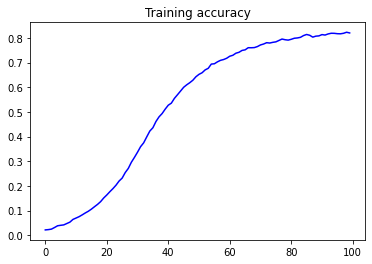

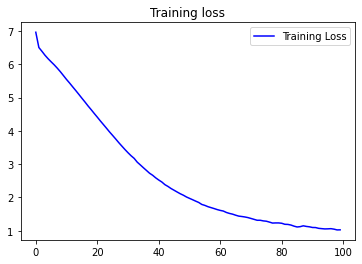

In [8]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [9]:
seed_text = "Help me Obi Wan Kenobi, you're my only hope"
next_words = 100
  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = model.predict_classes(token_list, verbose=0)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
Help me Obi Wan Kenobi, you're my only hope eye without thy side another verse age can lie write that me so not so dear one kill me had bearing none none friend desire ' still so none none give be hate on days none know you look in doubt life in one wrong might none stand through him till thee thence so green thee resort keep ere thence green me told they rolling none crime grew day through such hue thy growth of memory lie new new bright ' releasing so hate on me green bearing none woe tongue ' so 'no ' still ' releasing so 'will
